In [10]:
library("ggpubr")
library("tidyverse")
library(parallel)
library(lmerTest)
library(lme4)
suppressPackageStartupMessages(library(performance))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(pheatmap))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(plyr))
suppressPackageStartupMessages(library(ggrepel))
library(RColorBrewer)
library(viridis)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lme4

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step


Loading required package: viridisLite



In [13]:
Olnik<-read.csv('Olink.csv')

In [14]:
meta<-read.csv('/home/jupyter/BRI_Analysis/scRNA/hise_meta_data_2024-01-09.csv')
meta<-meta %>% filter(sample.visitName=='Flu Year 1 Day 0')

In [15]:
CMV=read.csv("/home//jupyter/BRI_Analysis/scRNA/CMV_20220718.csv") 
meta<-left_join(meta,CMV,by = c("subject.subjectGuid"))

In [16]:
rownames(meta)<-meta$sample.sampleKitGuid

In [17]:
n_distinct(meta$sample.sampleKitGuid)


[1] 92

In [18]:
Olnik<-Olnik %>% filter(sample.sampleKitGuid %in% unique(meta$sample.sampleKitGuid))

In [19]:
Olnik<-left_join(Olnik,meta, by = c("sample.sampleKitGuid"))

In [12]:
res_list<-mclapply(unique(Olnik$Assay),function(x){
Olnik_sub<-Olnik  %>% filter(sample.visitName=='Flu Year 1 Day 0',Assay==x)
res<-lm(NPX_bridged ~ cohort.cohortGuid+CMV.IgG.Serology.Result.Interpretation+subject.biologicalSex, data=Olnik_sub)
res<-as.data.frame(summary(res)$coefficients)[2:4,]
res$factor<-c('Age','CMV','Sex')  
res$Assay<-x
res$Log2FC_Age<-Olnik_sub %>%
  dplyr::group_by(Assay, cohort.cohortGuid) %>%
  dplyr::summarise(Mean_Expression = mean(NPX_bridged, na.rm = TRUE)) %>%
  spread(cohort.cohortGuid, Mean_Expression) %>%
  mutate(Log2FC = log2(BR2 / BR1))%>% ungroup() %>% select(Log2FC) %>% pull()
res$diff<-Olnik_sub %>%
  dplyr::group_by(Assay, cohort.cohortGuid) %>%
  dplyr::summarise(Mean_Expression = mean(NPX_bridged, na.rm = TRUE)) %>%
  spread(cohort.cohortGuid, Mean_Expression) %>%
  mutate(diff = BR2- BR1)%>% select(diff) %>% pull()    
return(res)
},mc.cores=60)

In [13]:
res_all<-do.call(rbind,res_list )

In [14]:
res_all_age<-res_all %>% filter(factor=='Age')
res_all_cmv<-res_all %>% filter(factor=='CMV')
res_all_sex<-res_all %>% filter(factor=='Sex')

In [15]:
res_all_age$padj<-p.adjust(res_all_age$`Pr(>|t|)`)
res_all_cmv$padj<-p.adjust(res_all_cmv$`Pr(>|t|)`)

In [16]:
data <- res_all_age%>% mutate(Expression = case_when(diff >=0.1 & padj <= 0.05 ~ "Up-regulated",
                                                     diff <= -0.1 & padj <= 0.05 ~ "Down-regulated",
                                                     TRUE ~ "Unchanged"))

In [17]:
top <- 30
top_genes <- bind_rows(
  data %>% 
    filter(Expression == 'Up-regulated') %>% 
    arrange(padj, desc(abs(diff))) %>% 
    head(top),
  data %>% 
    filter(Expression == 'Down-regulated') %>% 
    arrange(padj, desc(abs(diff))) %>% 
    head(top))

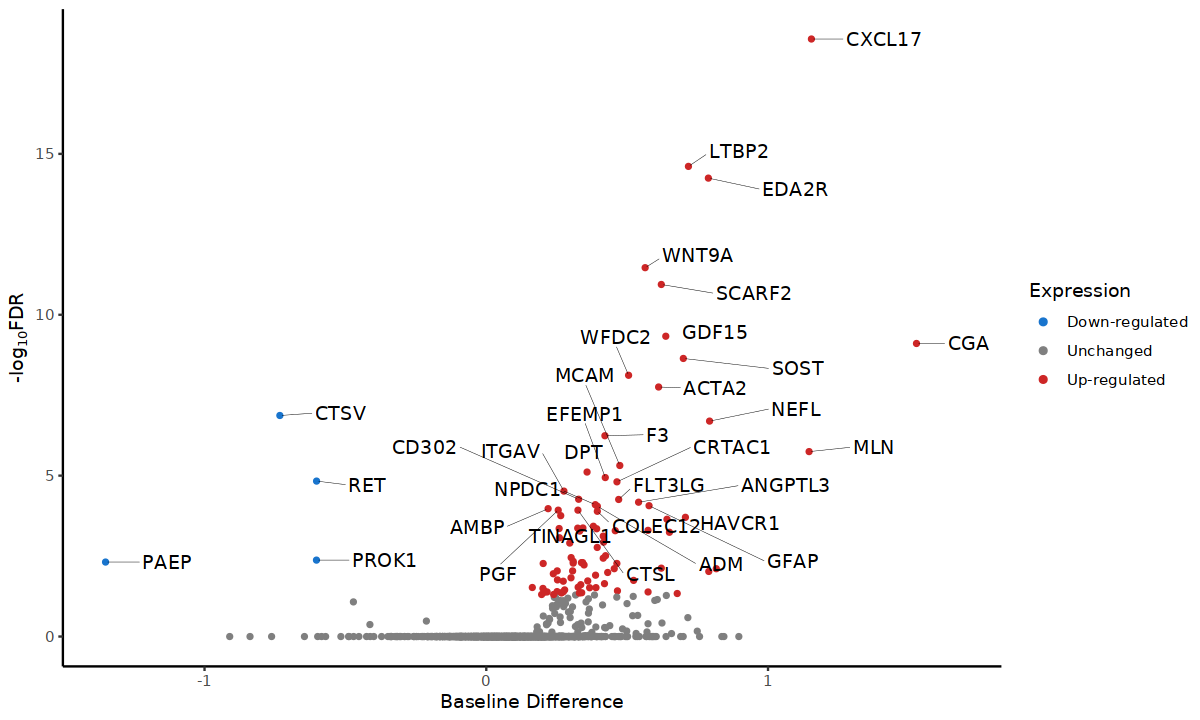

In [20]:
options(repr.plot.width = 10, repr.plot.height = 6)

ggplot(data, aes(diff, -log(padj,10))) +
  geom_point(aes(color = Expression), size = 1) +
  xlab(expression("Baseline Difference")) + 
  ylab(expression("-log"[10]*"FDR")) +
  scale_color_manual(values = c("Down-regulated"="dodgerblue3", "Unchanged"="gray50", "Up-regulated"="firebrick3")) +
  guides(colour = guide_legend(override.aes = list(size=1.5))) +
  geom_text_repel(data = top_genes,box.padding = 0.5,force= 0.5,max.overlaps=50,
    nudge_x           = 0.15,
    hjust             = 0.1,
    segment.size      = 0.1,
                   mapping = aes(diff, -log(padj,10), label = Assay),
                   size = 4)+theme_classic()


In [26]:
data$Log2FC_Age<-NULL

In [27]:
write.csv(data %>% arrange(padj),'Olink_Age.csv')

# Visualization

### Age

In [21]:
wide_format<-Olnik %>% filter(sample.visitName=='Flu Year 1 Day 0')%>% select(Assay,NPX_bridged,sample.sampleKitGuid)%>% 
  spread(key = sample.sampleKitGuid, value = NPX_bridged)

In [22]:
rownames(wide_format)<-wide_format$Assay

In [23]:
wide_format<-wide_format[-1]

In [24]:
gene_list<-res_all_age%>%arrange(padj) %>% filter(padj<0.05,abs(diff)>0.1) %>% select(Assay) %>% pull()

In [25]:
annotation_data<-meta[colnames(wide_format),]

In [26]:
annotation_data<-annotation_data %>% arrange(cohort.cohortGuid)

In [27]:
rownames(annotation_data)<-annotation_data$sample.sampleKitGuid

In [28]:
cols <- colorRampPalette(brewer.pal(9, "RdPu"))

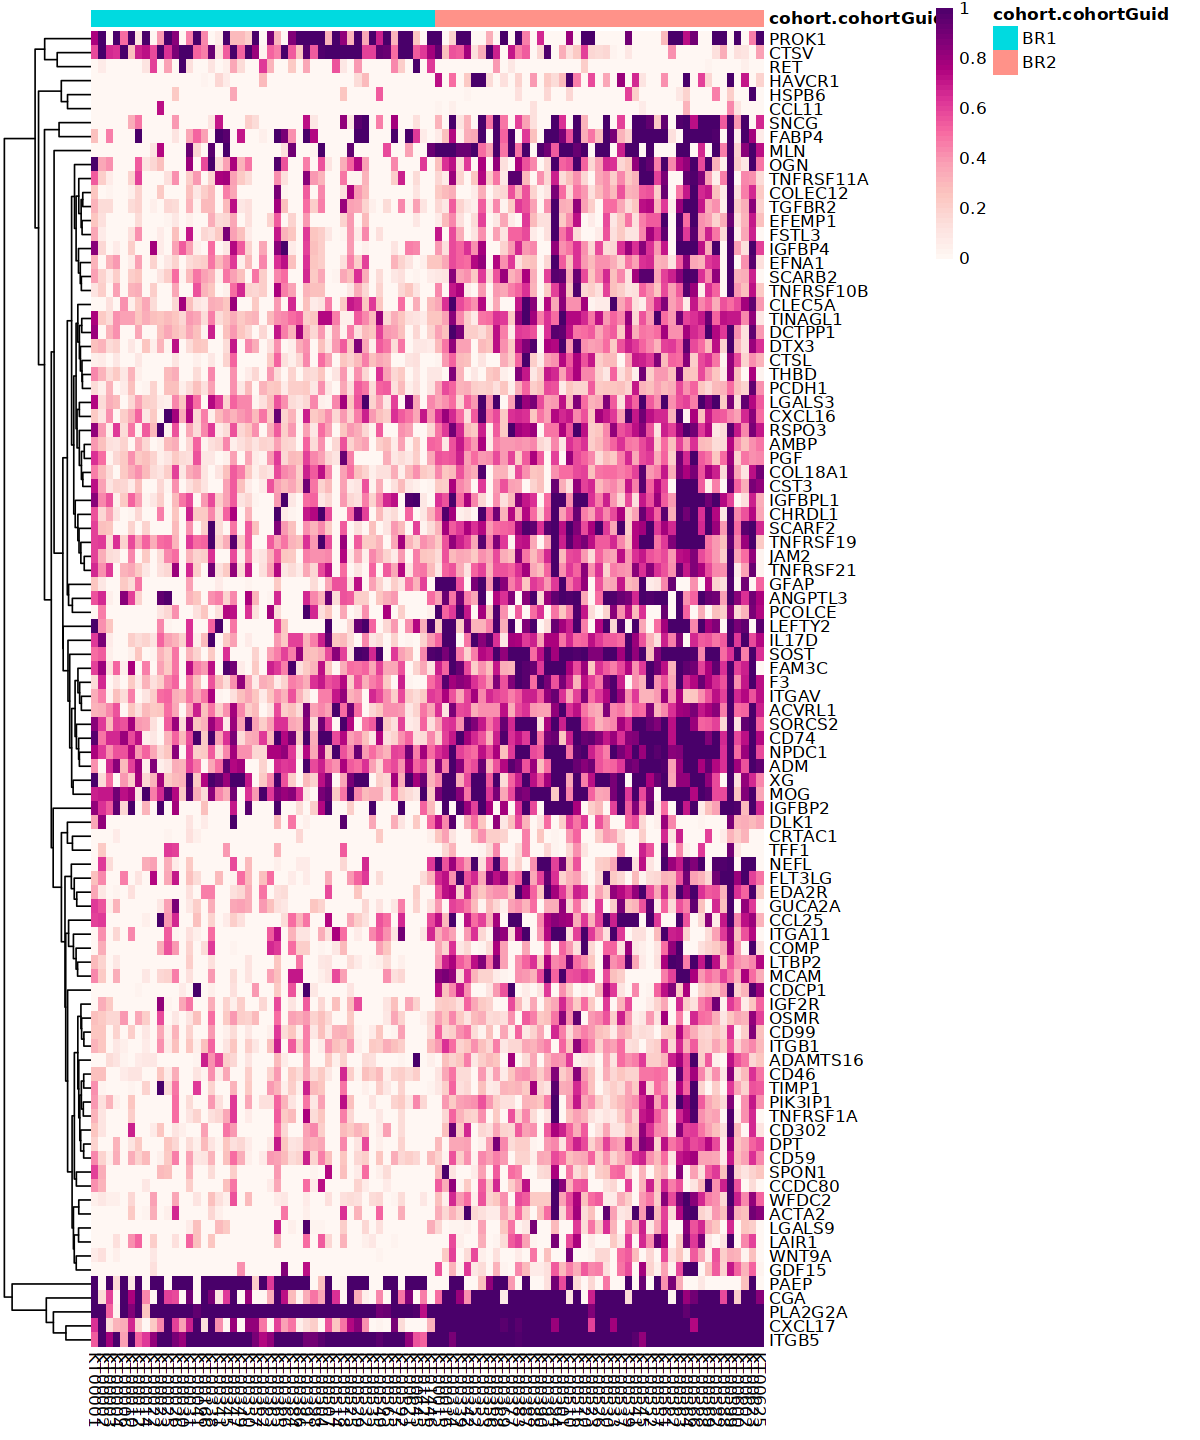

In [29]:
options(repr.plot.width = 10, repr.plot.height = 12)

pheatmap(wide_format[gene_list,annotation_data$sample.sampleKitGuid],breaks=seq(0, 1, length.out=50), 
         cluster_cols = FALSE,color=cols(50),
         annotation_col = annotation_data['cohort.cohortGuid'])

# Age by Female and Male

# Female

In [89]:
female_id<-Olnik %>% filter(subject.biologicalSex=='Female') %>% select(subject.subjectGuid)

In [90]:
set.seed(1) 
female_id<-sample(pull(unique(female_id)),41)

In [91]:
length(female_id)

[1] 41

In [92]:
res_list<-mclapply(unique(Olnik$Assay),function(x){
Olnik_sub<-Olnik  %>% filter(subject.subjectGuid%in% female_id,subject.biologicalSex=='Female',sample.visitName=='Flu Year 1 Day 0',Assay==x)
res<-lm(NPX_bridged ~ cohort.cohortGuid+CMV.IgG.Serology.Result.Interpretation, data=Olnik_sub)
res<-as.data.frame(summary(res)$coefficients)[2:3,]
res$factor<-c('Age','CMV')  
res$Assay<-x
res$Log2FC_Age<-Olnik_sub %>%
  dplyr::group_by(Assay, cohort.cohortGuid) %>%
  dplyr::summarise(Mean_Expression = mean(NPX_bridged, na.rm = TRUE)) %>%
  spread(cohort.cohortGuid, Mean_Expression) %>%
  mutate(Log2FC = log2(BR2 / BR1))%>% ungroup() %>% select(Log2FC) %>% pull()
res$diff<-Olnik_sub %>%
  dplyr::group_by(Assay, cohort.cohortGuid) %>%
  dplyr::summarise(Mean_Expression = mean(NPX_bridged, na.rm = TRUE)) %>%
  spread(cohort.cohortGuid, Mean_Expression) %>%
  mutate(diff = BR2- BR1)%>% select(diff) %>% pull()    
return(res)
},mc.cores=60)

In [93]:
res_all<-do.call(rbind,res_list )
res_all_age_Female<-res_all %>% filter(factor=='Age')
res_all_age_Female$padj<-p.adjust(res_all_age_Female$`Pr(>|t|)`)
write.csv(res_all_age_Female,'res_all_age_Female.csv')

In [94]:
data <- res_all_age_Female%>% mutate(Expression = case_when(diff >=0.1 & padj <= 0.05 ~ "Up-regulated-BR2",
                                                     diff <= -0.1 & padj <= 0.05 ~ "Down-regulated-BR2",
                                                     TRUE ~ "Unchanged"))

In [95]:
top <- 30
top_genes <- bind_rows(
  data %>% 
    filter(Expression == 'Up-regulated-BR2') %>% 
    arrange(padj, desc(abs(diff))) %>% 
    head(top),
  data %>% 
    filter(Expression == 'Down-regulated-BR2') %>% 
    arrange(padj, desc(abs(diff))) %>% 
    head(top))

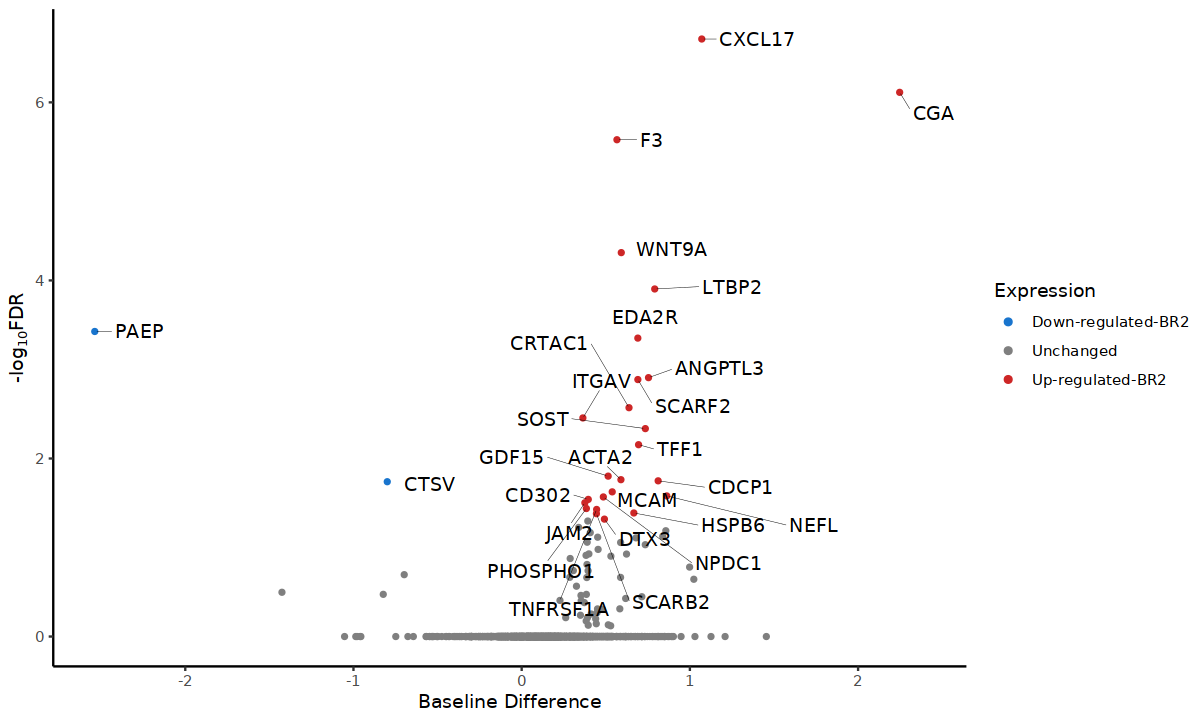

In [96]:
options(repr.plot.width = 10, repr.plot.height = 6)

ggplot(data, aes(diff, -log(padj,10))) +
  geom_point(aes(color = Expression), size = 1) +
  xlab(expression("Baseline Difference")) + 
  ylab(expression("-log"[10]*"FDR")) +
  scale_color_manual(values = c("Down-regulated-BR2"="dodgerblue3", "Unchanged"="gray50", "Up-regulated-BR2"="firebrick3")) +
  guides(colour = guide_legend(override.aes = list(size=1.5))) +
  geom_text_repel(data = top_genes,box.padding = 0.5,force= 0.5,max.overlaps=50,
    nudge_x           = 0.15,
    hjust             = 0.1,
    segment.size      = 0.1,
                   mapping = aes(diff, -log(padj,10), label = Assay),
                   size = 4)+theme_classic()


# Male

In [63]:
res_list<-mclapply(unique(Olnik$Assay),function(x){
Olnik_sub<-Olnik  %>% filter(subject.biologicalSex=='Male',sample.visitName=='Flu Year 1 Day 0',Assay==x)
res<-lm(NPX_bridged ~ cohort.cohortGuid+CMV.IgG.Serology.Result.Interpretation, data=Olnik_sub)
res<-as.data.frame(summary(res)$coefficients)[2:3,]
res$factor<-c('Age','CMV')  
res$Assay<-x
res$Log2FC_Age<-Olnik_sub %>%
  dplyr::group_by(Assay, cohort.cohortGuid) %>%
  dplyr::summarise(Mean_Expression = mean(NPX_bridged, na.rm = TRUE)) %>%
  spread(cohort.cohortGuid, Mean_Expression) %>%
  mutate(Log2FC = log2(BR2 / BR1))%>% ungroup() %>% select(Log2FC) %>% pull()
res$diff<-Olnik_sub %>%
  dplyr::group_by(Assay, cohort.cohortGuid) %>%
  dplyr::summarise(Mean_Expression = mean(NPX_bridged, na.rm = TRUE)) %>%
  spread(cohort.cohortGuid, Mean_Expression) %>%
  mutate(diff = BR2- BR1)%>% select(diff) %>% pull()    
return(res)
},mc.cores=60)

In [64]:
res_all<-do.call(rbind,res_list )
res_all_age_Male<-res_all %>% filter(factor=='Age')
res_all_age_Male$padj<-p.adjust(res_all_age_Male$`Pr(>|t|)`)
write.csv(res_all_age_Male,'res_all_age_Male.csv')

In [55]:
data <- res_all_age_Male%>% mutate(Expression = case_when(diff >=0.1 & padj <= 0.05 ~ "Up-regulated-BR2",
                                                     diff <= -0.1 & padj <= 0.05 ~ "Down-regulated-BR2",
                                                     TRUE ~ "Unchanged"))

In [56]:
top <- 30
top_genes <- bind_rows(
  data %>% 
    filter(Expression == 'Up-regulated-BR2') %>% 
    arrange(padj, desc(abs(diff))) %>% 
    head(top),
  data %>% 
    filter(Expression == 'Down-regulated-BR2') %>% 
    arrange(padj, desc(abs(diff))) %>% 
    head(top))

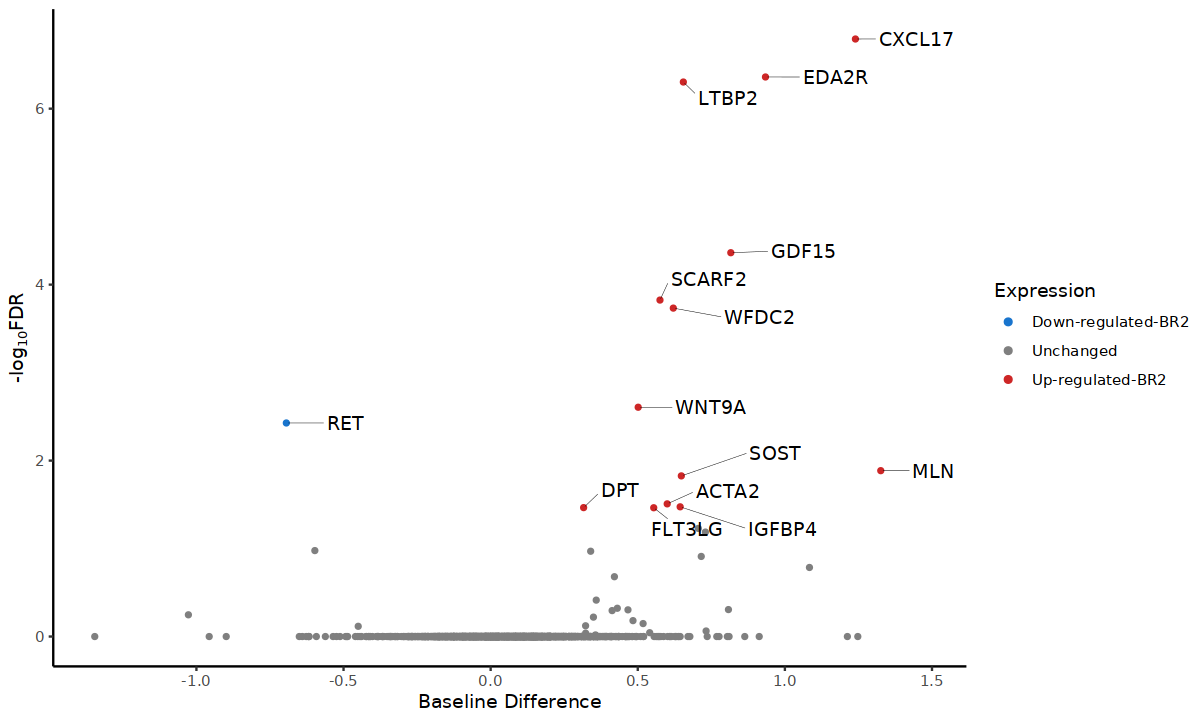

In [57]:
options(repr.plot.width = 10, repr.plot.height = 6)

ggplot(data, aes(diff, -log(padj,10))) +
  geom_point(aes(color = Expression), size = 1) +
  xlab(expression("Baseline Difference")) + 
  ylab(expression("-log"[10]*"FDR")) +
  scale_color_manual(values = c("Down-regulated-BR2"="dodgerblue3", "Unchanged"="gray50", "Up-regulated-BR2"="firebrick3")) +
  guides(colour = guide_legend(override.aes = list(size=1.5))) +
  geom_text_repel(data = top_genes,box.padding = 0.5,force= 0.5,max.overlaps=50,
    nudge_x           = 0.15,
    hjust             = 0.1,
    segment.size      = 0.1,
                   mapping = aes(diff, -log(padj,10), label = Assay),
                   size = 4)+theme_classic()
